In [1]:
# loading libraries

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch

/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Entre cada uno de los integrantes del grupo fuimos obteniendo distintos features que nos parecieron interesantes y que consideramos que podrian servir para las predicciones.

#### Leemos los distintos CSVs que contienen los features


In [2]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv').drop(columns='Unnamed: 0')
features_ari = pd.read_csv('../features/features_ariel.csv')
#features_mati = pd.read_csv('../features/events_qty_per_person.csv')
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')

## Mergeamos todos los features en un solo dataframe de la forma <persona, feature1, feature2,...,...>

In [3]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df.head()

person  marca_favorita_apple  marca_favorita_asus  marca_favorita_lenovo  \
0  0008ed71                     1                    0                      0   
1  00091926                     1                    0                      0   
2  00091a7a                     1                    0                      0   
3  000ba417                     0                    0                      0   
4  000c79fe                     1                    0                      0   

   marca_favorita_lg  marca_favorita_motorola  marca_favorita_no tiene  \
0                  0                        0                        0   
1                  0                        0                        0   
2                  0                        0                        0   
3                  0                        0                        0   
4                  0                        0                        0   

   marca_favorita_quantum  marca_favorita_samsung  marca_favorita_sony  \
0                       0                       0                    0   
1                       0                       0                    0   
2                       0                       0                    0   
3                       0                       1                    0   
4                       0                       0                    0   

              ...              cant_buenos  condicion_de_producto_moda  \
0             ...                        2                      buenos   
1             ...                      102                  muy buenos   
2             ...                        1                  excelentes   
3             ...                      115                      buenos   
4             ...                        4                      buenos   

   has_converted_before  most_viewed_sku  most_viewed_color_Preto  \
0                   0.0           3372.0                        1   
1                   0.0           8568.0                        0   
2                   0.0           1357.0                        0   
3                   1.0           2988.0                        1   
4                   0.0           9944.0                        0   

   most_viewed_color_Branco  most_viewed_color_Dourado  \
0                         0                          0   
1                         0                          1   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   region_brasil_Sao Paulo  region_brasil_Unknown  region_brasil_Minas Gerais  
0                        0                      1                           0  
1                        0                      0                           0  
2                        0                      0                           1  
3                        1                      0                           0  
4                        0                      0                           1  

[5 rows x 47 columns]

## Al dataframe de las personas con sus features le agregamos los labels para saber si cada persona o no realizo una compra.

## Tambien tenemos un dataframe de test, el cual contiene todas las personas que queremos predecir y sus features ( queremos predecir sus labels)

In [4]:
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')
training_set.drop(columns= 'Unnamed: 0', inplace=True)

## Como se puede observar en nuestro set de entrenamiento predomina el label 0, la mayoria de las personas no realizo una conversion, esto debemos balancearlo.

In [5]:
training_set['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

## Elimino 17500 filas que contienen el label 0 para balancear el set de entrenamiento.

# <font color='red'> Preguntar de cual es la mejor manera de hacer esto</font>

In [6]:
r_training_set = training_set.drop(training_set[training_set.label.eq(0)].sample(17500).index)
r_training_set['label'].value_counts()

1    980
0    934
Name: label, dtype: int64

In [7]:
r_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 13 to 19409
Data columns (total 47 columns):
person                                   1914 non-null object
marca_favorita_apple                     1914 non-null int64
marca_favorita_asus                      1914 non-null int64
marca_favorita_lenovo                    1914 non-null int64
marca_favorita_lg                        1914 non-null int64
marca_favorita_motorola                  1914 non-null int64
marca_favorita_no tiene                  1914 non-null int64
marca_favorita_quantum                   1914 non-null int64
marca_favorita_samsung                   1914 non-null int64
marca_favorita_sony                      1914 non-null int64
nivel_de_actividad_Muy Bajo              1914 non-null int64
nivel_de_actividad_Bajo                  1914 non-null int64
nivel_de_actividad_Medio                 1914 non-null int64
nivel_de_actividad_Alto                  1914 non-null int64
nivel_de_actividad_Muy Alto         

## En el siguiente array incluimos los features que mas aportan para las predicciones

In [8]:
features = ['cant_total_eventos', #0
            'marca_favorita_apple',#1
            'mean_events_per_day',#2
            'has_converted_before',#3
            'most_viewed_sku',#4
            'most_viewed_color_Preto',#5
            'most_viewed_color_Branco',#6
            #'most_viewed_color_Dourado', #7
            #'region_brasil_Sao Paulo',#8
            #'region_brasil_Unknown',#9
            #'region_brasil_Minas Gerais',#10
            'marca_favorita_samsung',#11
            'cant_ev_noche',#12
            'cant_ev_manana',
            'cant_ev_tarde',
            'cant_ev_madrugada',
            'cant_buenos',
            'cant_muy_buenos',
            'cant_excelentes'
            #'nivel_de_actividad_Muy Bajo',#13
            #'nivel_de_actividad_Muy Alto',#14
            #'nivel_de_actividad_Bajo',#15
            #'nivel_de_actividad_Medio',#16
            #'nivel_de_actividad_Alto'#17
           ]

## Creo dos arrays el llamado X es generado a partir de mi dataframe de entrenamiento y los features que quiero tener en cuenta
## Y el segundo Y es generado a partir de sus labels

In [9]:
x = np.array(r_training_set[features])
y = np.array(r_training_set['label'])

## Usamos train_test_split para dividir el dataframe de entrenamiento en uno de test y otro de entrenamiento

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)

## El primer algoritmo que utilizamos es KNN

### En el siguiente loop iremos probando KNN con distintos Ks y nos quedaremos con la que obtuvimos mayor accuracy.

In [11]:
best_accuracy = 0
worst_accuracy = 1
best_k = 1
worst_k = 0
best_prediction = []
#acumulated_acuracy = 0
#loop_count = 0;

for i in xrange(1,203,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = (knn.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test,pred.round(), normalize=False)
    if (accuracy > best_accuracy) :
        best_k = i
        best_accuracy = accuracy
        best_prediction = pred
    if (accuracy < worst_accuracy) : 
        worst_accuracy = accuracy
        worst_k = i
    #loop_count += 1
    #acumulated_acuracy += accuracy
    #X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)
        

In [12]:
print 'Best accuracy: ' + str(best_accuracy / float(best_prediction.size)) + ' with k='  + str(best_k)
print 'Worst accuracy: ' + str(worst_accuracy / float(best_prediction.size)) + ' with k= ' + str(worst_k)
#print "Median accuracy " + str(acumulated_acuracy / (float(loop_count) * float(best_prediction.size)))

Best accuracy: 0.6458333333333334 with k=99
Worst accuracy: 0.00520833333333 with k= 0


## Finalmente corremos KNN con el mejor K obtenido en el entrenamiento y el set que queremos predecir

In [13]:
z = np.array(test_set[features])
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x,y)
pred = knn.predict_proba(z)[:,1]

## Le agregamos las predicciones a los IDs de las personas y lo guardamos en un archivo.


In [14]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/knn.csv', index=False)

## Revisamos la cantidad de conversiones y no conversiones predichas

### Se tienen que repartir en un 50/50

In [15]:
conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

no_conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

Cantidad de conversiones: 11006
Cantidad de no conversiones: 8409


## XGBoost

### En los siguientes arrays, ponemos los posibles hiperparametros que concideramos que mejor funcionarian para las predicciones.

### Con grid search probamos todas las combinaciones posibles y nos quedamos con la que mayor accuracy nos dio.

In [16]:
n_estimators = [100, 200, 1500, 2000]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01]
subsample = [0.3, 0.5, 0.7]
gamma = [0.6, 0.7]
colsample_bytree = [0.5, 0.7]


param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,
                 learning_rate=learning_rate, subsample=subsample,
                 gamma=gamma)


In [17]:
#kfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=7)
#grid_search = GridSearch(xgboost, param_grid, scoring="neg_log_loss", n_jobs = 1, cv=kfold, verbose=1)
#result = grid_search.fit(x,y)

In [18]:
#print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [19]:
#means = result.cv_results_['mean_test_score']
#stds = result.cv_results_['std_test_score']
#params = result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

### Corremos XGBoost para el set de entrenamiento y medimos su precision

In [20]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 4,\
                            min_child_weight= 2,\
                            gamma=0.6,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1)

xgboost.fit(X_train, y_train)
pred = (xgboost.predict_proba(X_test)[:,1])
accuracy = accuracy_score(y_test, pred.round(), normalize=False)

print("Accuracy: ", accuracy / float(pred.size))

('Accuracy: ', 0.6354166666666666)


## Analizamos cuales son los features que mayor peso tienen para xgboost.

In [21]:
print(xgboost.feature_importances_)

[0.13749027 0.02011553 0.15547544 0.0231472  0.15895776 0.01102053
 0.00528494 0.01327379 0.10856652 0.02654758 0.07583269 0.04076365
 0.08005244 0.08386251 0.05960916]


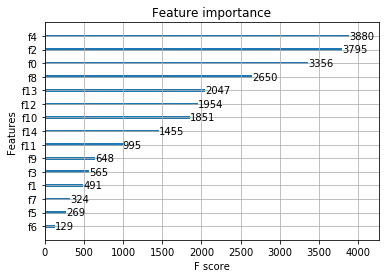

In [22]:
plot_importance(xgboost)
pyplot.show()

In [23]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 4,\
                            min_child_weight= 2,\
                            gamma=0.6,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1)
xgboost.fit(x,y)
pred = (xgboost.predict_proba(z)[:,1])

In [24]:
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)

In [25]:
conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

no_conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

Cantidad de conversiones: 11883
Cantidad de no conversiones: 7532
